In [1]:
!pip install einops


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tqdm
import random
import collections
from pathlib import Path
import shutil

import cv2
import einops
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [3]:
import collections
import random
from pathlib import Path
import shutil
import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import math

def list_files_per_class(root_dir):
    """
    List the files in each class of the dataset given the root directory.

    Args:
      root_dir: Root directory where files are unzipped.

    Return:
      files: List of files in each of the classes.
    """
    files = []
    root_path = Path(root_dir)
    for file_path in root_path.rglob('*'):  # Recursively list all files
        if file_path.is_file():
            files.append(str(file_path.relative_to(root_path)))
    return files

def get_class(fname):
    """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF50 dataset.

    Return:
      Class that the file belongs to.
    """
    return fname.split('_')[-3]

def get_files_per_class(files):
    """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

def split_class_lists(files_for_class, count):
    """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

def organize_dataset(root_dir, num_classes, splits):
    """
    Organize a dataset into class-based directories and split them into various parts.

    Args:
      root_dir: Root directory where files are currently unzipped.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).

    Return:
      split_files: Dictionary of split names and their corresponding file lists.
    """
    files = list_files_per_class(root_dir)
    files_for_class = get_files_per_class(files)
    
    classes = list(files_for_class.keys())[:num_classes]
    
    for cls in classes:
        random.shuffle(files_for_class[cls])
    
    # Filter for the desired number of classes
    files_for_class = {cls: files_for_class[cls] for cls in classes}
    
    split_files = {}
    for split_name, split_count in splits.items():
        split_files[split_name], files_for_class = split_class_lists(files_for_class, split_count)
    
    return split_files

def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to be resized and padded.
      output_size: Pixel size of the output frame image (height, width).

    Returns:
      Formatted frame with padding of specified output size.
    """
    frame = frame.astype(float) / 255.0
    frame = np.transpose(frame, (2, 0, 1))
    transform = T.Compose([
        T.Resize(output_size)
    ])
    frame = transform(torch.from_numpy(frame))
    return frame

def set_frame_step(video_length, n_frames):
    frame_step = math.floor(video_length / n_frames)
    return frame_step

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    if frame_step < 0:
        frame_step = set_frame_step(video_length, n_frames)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, int(max_start) + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for i in range(n_frames - 1):
        for j in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)  # [..., [2, 1, 0]]
    return np.transpose(result, (1, 2, 3, 0))

class FrameGeneratorDataset(Dataset):
    def __init__(self, file_paths, root_dir, n_frames, training=False, frame_step=15):
        """
        Returns a set of frames with their associated label.

        Args:
          file_paths: List of file paths.
          root_dir: Root directory where files are stored.
          n_frames: Number of frames to extract from each video.
          training: Boolean indicating if this is the training dataset (to enable shuffling).
        """
        self.file_paths = file_paths
        self.root_dir = Path(root_dir)
        self.n_frames = n_frames
        self.training = training
        self.frame_step = frame_step

        # Get all class names and assign a unique ID to each
        self.class_names = sorted(set(get_class(p) for p in self.file_paths))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

        # Shuffle the file paths if in training mode
        if self.training:
            random.shuffle(self.file_paths)

    def __len__(self):
        # Return the number of video files available
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Retrieve frames and the label for a given video index.

        Args:
          idx: Index of the video to retrieve.

        Returns:
          A tuple (frames, label) where frames are the extracted frames from the video,
          and label is the encoded class label.
        """
        fname = self.file_paths[idx]
        path = self.root_dir / fname
        class_name = get_class(fname)

        # Extract frames from the video file
        video_frames = frames_from_video_file(path, self.n_frames, frame_step=self.frame_step)

        # Get label by encoding the class name
        label = self.class_ids_for_name[class_name]

        # Convert frames and label to tensors
        video_frames = torch.tensor(video_frames, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.int64)

        return video_frames, label

In [4]:
root_dir = 'raw/UCF50'
num_classes = 50
subset_paths = organize_dataset(root_dir,
                        num_classes = num_classes,
                        splits = {"train": 70, "val": 15, "test": 15})

In [5]:
# Parameters
n_frames = 20
batch_size = 128

# Dataset paths
train_dataset = FrameGeneratorDataset(subset_paths['train'], root_dir, n_frames, training=True, frame_step=-1)
val_dataset = FrameGeneratorDataset(subset_paths['val'], root_dir, n_frames, training=False, frame_step=-1)
test_dataset = FrameGeneratorDataset(subset_paths['test'], root_dir, n_frames, training=False, frame_step=-1)

# DataLoaders with batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [7]:
class Conv2Plus1D(nn.Module):
    def __init__(self, input_channels, filters, kernel_size, device):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension.

        Args:
          filters (int): Number of filters in each convolutional layer.
          kernel_size (tuple): Kernel size for the convolution in (depth, height, width).
        """
        super(Conv2Plus1D, self).__init__()

        padding_spatial = (0, kernel_size[1] // 2, kernel_size[2] // 2)
        padding_temporal = (kernel_size[0] // 2, 0, 0)

        # Sequential container for spatial and temporal convolution
        self.seq = nn.Sequential(
            # Spatial decomposition
            nn.Conv3d(in_channels=input_channels,
                      out_channels=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding_spatial,
                      device=device),
            # Temporal decomposition
            nn.Conv3d(in_channels=filters,
                      out_channels=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding_temporal,
                      device=device)
        )

    def forward(self, x):
        return self.seq(x)

In [8]:
class ResidualMain(nn.Module):
    """
    Residual block of the model with convolution, layer normalization, and ReLU activation.
    """
    def __init__(self, input_channels, filters, kernel_size, height, width, device):
        super(ResidualMain, self).__init__()
        self.conv1 = Conv2Plus1D(input_channels=input_channels, filters=filters, kernel_size=kernel_size, device=device)
        self.norm = nn.LayerNorm(normalized_shape=(filters, ), eps=1e-3, device=device)
        self.conv2 = Conv2Plus1D(input_channels=filters, filters=filters, kernel_size=kernel_size, device=device)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        x = self.conv1(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)

        # Apply ReLU
        x = self.relu(x)

        # Second convolution
        x = self.conv2(x)

        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)

        return x

In [9]:
class Project(nn.Module):
    """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
    """
    def __init__(self, units, height, width, device):
        super(Project, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=units[0], out_features=units[1], device=device),  # Linear projection
            nn.LayerNorm(units[1], device=device)
        )

    def forward(self, x):
        return self.seq(x)


In [10]:
def resize_video(video, height, width):
    """
    Resize the tensor using einops and PyTorch's interpolation.

    Args:
      video (torch.Tensor): Tensor representation of the video, as a batch of frames.

    Returns:
      torch.Tensor: Resized video tensor with the new height and width.
    """
    # Parse the shape and rearrange for resizing
    old_shape = einops.parse_shape(video, 'b c h w t')
    images = einops.rearrange(video, 'b c h w t -> b t h w c')
    images = einops.rearrange(images, 'b t h w c -> (b t) h w c')

    # Resize images using interpolate
    images = F.interpolate(images.permute(0, 3, 1, 2), size=(height, width), mode='bilinear', align_corners=False)
    images = images.permute(0, 2, 3, 1)  # Convert back to (batch, height, width, channels)

    # Reshape back to video format
    videos = einops.rearrange(images, '(b t) h w c -> b t h w c', t=old_shape['t'])
    output = einops.rearrange(videos, 'b t h w c -> b c h w t')
    return output


In [11]:
class VideoModel(nn.Module):
    def __init__(self, height, width, device):
        super(VideoModel, self).__init__()
        self.height = height
        self.width = width
        kernel_size = (3,3,3)

        self.conv = Conv2Plus1D(input_channels=3, filters=16, kernel_size=(3, 7, 7), device=device)
        self.norm = nn.LayerNorm(normalized_shape=(16, ), eps=1e-3, device=device)
        self.relu = nn.ReLU()

        self.residual1 = ResidualMain(16, 16, kernel_size, self.height // 2, self.width // 2, device)
        self.residual2 = ResidualMain(16, 32, kernel_size, self.height // 4, self.width // 4, device)
        self.residual3 = ResidualMain(32, 64, kernel_size, self.height // 8, self.width // 8, device)
        self.residual4 = ResidualMain(64, 128, kernel_size, self.height // 16, self.width // 16, device)

        self.project1 = Project(units=(16, 32), height=self.height // 2, width=self.width // 2, device=device)
        self.project2 = Project(units=(32, 64), height=self.height // 4, width=self.width // 4, device=device)
        self.project3 = Project(units=(64, 128), height=self.height // 8, width=self.width // 8, device=device)

        # Pooling and Output Layers
        self.global_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, num_classes)  # Adjust the input to `Linear` based on the final channel size

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 4, 2, 3, 1)
        x = self.relu(x)

        x = resize_video(x, self.height // 2, self.width // 2)
        out = self.residual1(x)
        x = torch.add(x, out)

        resized_x = resize_video(x, self.height // 4, self.width // 4)
        projected_x = self.project1(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual2(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)
        
        resized_x = resize_video(x, self.height // 8, self.width // 8)
        projected_x = self.project2(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual3(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)
        
        resized_x = resize_video(x, self.height // 16, self.width // 16)
        projected_x = self.project3(resized_x.permute(0, 4, 2, 3, 1))
        residual_x = self.residual4(resized_x)
        x = torch.add(projected_x.permute(0, 4, 2, 3, 1), residual_x)

        # Global average pooling and flatten
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [12]:
from tqdm import tqdm
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for frames, labels in tqdm(val_loader,desc="Val",total=len(val_loader)):
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy
    

# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for frames, labels in tqdm(train_loader,desc="Train",total=len(train_loader)):
            frames, labels = frames.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            
        train_accuracy = correct / total
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        train_loss = running_loss / len(train_loader)

        if val_accuracy > best:
              torch.save(model.state_dict(), "best_adaptive_v1.pt")
              best = val_accuracy
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return history

In [13]:
import torch.optim as optim

# Set up the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VideoModel(height=HEIGHT, width=WIDTH, device=device).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
model.load_state_dict(torch.load('best_adaptive.pt'))

/tmp/ipykernel_2991503/179640512.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_adaptive.pt'))


<All keys matched successfully>

In [18]:
# Training

history = train_model(model, optimizer, criterion, train_loader, val_loader)

Val: 100%|██████████| 6/6 [01:12<00:00, 12.00s/it]


Epoch [1/20], Train Loss: 2.6980, Train Acc: 0.2874, Val Loss: 2.6528, Val Acc: 0.3027


Val: 100%|██████████| 6/6 [01:14<00:00, 12.37s/it]


Epoch [2/20], Train Loss: 2.6376, Train Acc: 0.2977, Val Loss: 2.5877, Val Acc: 0.3413


Val: 100%|██████████| 6/6 [01:20<00:00, 13.42s/it]


Epoch [3/20], Train Loss: 2.6074, Train Acc: 0.3151, Val Loss: 2.6010, Val Acc: 0.3213


Val: 100%|██████████| 6/6 [01:02<00:00, 10.37s/it]


Epoch [4/20], Train Loss: 2.5599, Train Acc: 0.3246, Val Loss: 2.5592, Val Acc: 0.3293


Val: 100%|██████████| 6/6 [00:59<00:00,  9.84s/it]


Epoch [5/20], Train Loss: 2.5055, Train Acc: 0.3414, Val Loss: 2.5012, Val Acc: 0.3467


Val: 100%|██████████| 6/6 [00:59<00:00,  9.94s/it]


Epoch [6/20], Train Loss: 2.4840, Train Acc: 0.3489, Val Loss: 2.5208, Val Acc: 0.3373


Val: 100%|██████████| 6/6 [01:18<00:00, 13.04s/it]


Epoch [7/20], Train Loss: 2.4804, Train Acc: 0.3434, Val Loss: 2.4891, Val Acc: 0.3360


Val: 100%|██████████| 6/6 [01:16<00:00, 12.72s/it]


Epoch [8/20], Train Loss: 2.4252, Train Acc: 0.3694, Val Loss: 2.4553, Val Acc: 0.3827


Val: 100%|██████████| 6/6 [00:51<00:00,  8.65s/it]


Epoch [9/20], Train Loss: 2.3996, Train Acc: 0.3694, Val Loss: 2.4045, Val Acc: 0.3907


Train:  43%|████▎     | 12/28 [03:06<04:08, 15.55s/it]


KeyboardInterrupt: 

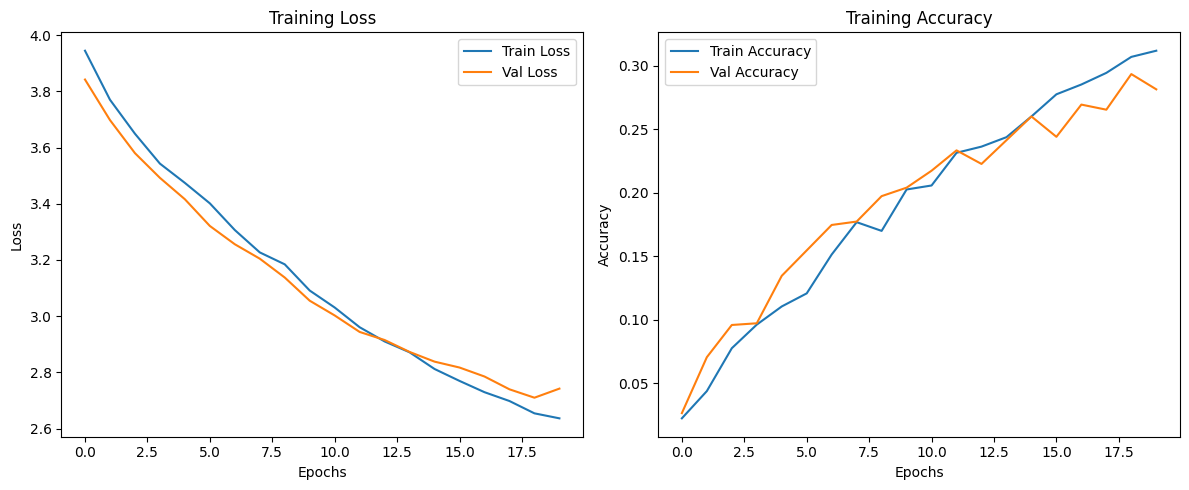

In [15]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting training losses and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label='Train Loss')
plt.plot(history["val_loss"], label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_accuracy"], label='Train Accuracy')
plt.plot(history["val_accuracy"], label='Val Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Generate actual and predicted labels
def get_actual_predicted_labels(model, dataset_loader):
    model.eval()
    actual = []
    predicted = []
    all_probas = []
    with torch.no_grad():
        for frames, labels in dataset_loader:
            frames = frames.to(device)
            outputs = model(frames)
            _, preds = torch.max(outputs, 1)
            actual.append(labels.cpu())
            predicted.append(preds.cpu())
            
            # Apply softmax to get probabilities
            probas = F.softmax(outputs, dim=1)
            all_probas.append(probas.cpu())

    # Concatenate all batches into single arrays
    all_probas = torch.cat(all_probas, dim=0).numpy()
    actual = torch.cat(actual, dim=0).numpy()
    predicted = torch.cat(predicted, dim=0).numpy()
    return actual, predicted, all_probas

In [20]:
evaluate_model(model, test_loader, criterion)

Val: 100%|██████████| 6/6 [00:51<00:00,  8.66s/it]


(2.4017584323883057, 0.364)

In [21]:
y_true, y_pred, y_proba = get_actual_predicted_labels(model, test_loader)

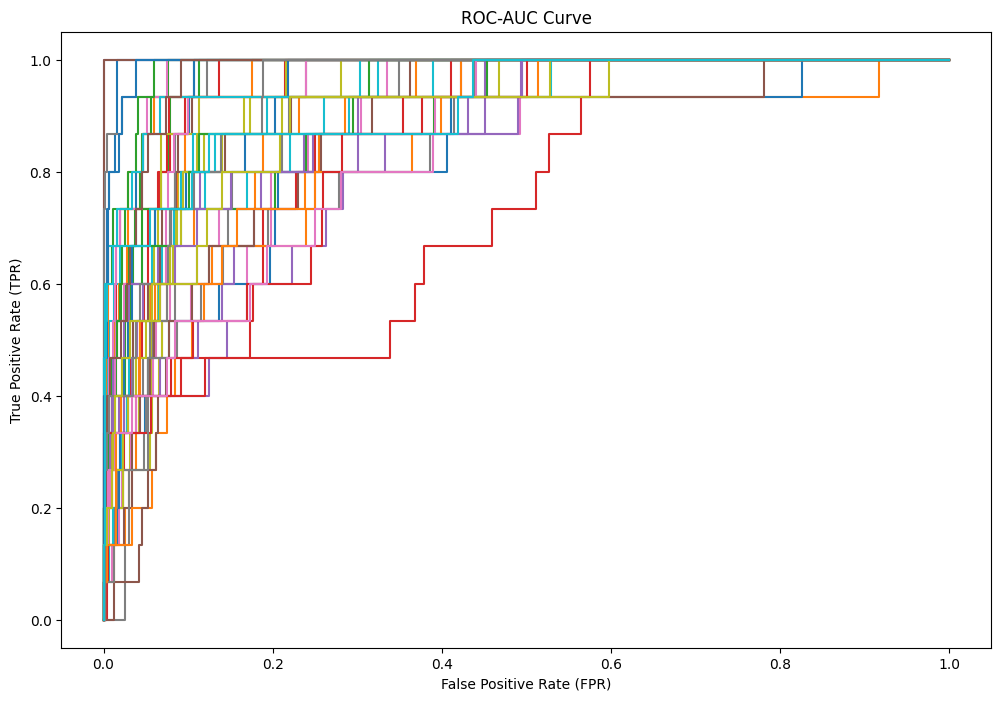

F1 per class:
Class 0 - 0.7222222222222222
Class 1 - 0.11764705882352941
Class 2 - 0.32786885245901637
Class 3 - 0.4827586206896552
Class 4 - 1.0
Class 5 - 0.9285714285714286
Class 6 - 0.25
Class 7 - 0.7647058823529411
Class 8 - 0.0
Class 9 - 0.5161290322580645
Class 10 - 0.42424242424242425
Class 11 - 0.46153846153846156
Class 12 - 0.47058823529411764
Class 13 - 0.23809523809523808
Class 14 - 0.2857142857142857
Class 15 - 0.38095238095238093
Class 16 - 0.09090909090909091
Class 17 - 0.26666666666666666
Class 18 - 0.26666666666666666
Class 19 - 0.3333333333333333
Class 20 - 0.19047619047619047
Class 21 - 0.5625
Class 22 - 0.0
Class 23 - 0.2727272727272727
Class 24 - 0.26666666666666666
Class 25 - 0.09090909090909091
Class 26 - 0.55
Class 27 - 0.0
Class 28 - 0.11764705882352941
Class 29 - 0.48484848484848486
Class 30 - 0.375
Class 31 - 0.08
Class 32 - 0.4878048780487805
Class 33 - 0.25
Class 34 - 0.3157894736842105
Class 35 - 0.07142857142857142
Class 36 - 0.3888888888888889
Class 37 - 

In [22]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score


# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

roc_auc_per_class = []

# Plotting ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    y_true_binary = (y_true == i).astype(int)
    roc_auc = roc_auc_score(y_true_binary, y_proba[:, i])
    roc_auc_per_class.append(roc_auc)
    fpr, tpr, _ = roc_curve(y_true_binary, y_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_per_class[i]:.2f})')

# Macro average ROC-AUC
roc_auc_macro = np.mean(roc_auc_per_class)

plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
# plt.legend()
plt.show()

# Output metrics
print("F1 per class:")
for i in range(num_classes):
    print("Class", i, "-", f1[i])
print()

print("Precision per class:")
for i in range(num_classes):
    print("Class", i, "-", precision[i])
print()

print("Recall per class:")
for i in range(num_classes):
    print("Class", i, "-", recall[i])
print()

print("ROC-AUC per class:")
for i in range(num_classes):
    print("Class", i, "-", roc_auc_per_class[i])
    
print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")